In [1]:
import gym

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn
from sklearn.metrics import mean_squared_error, r2_score

import pickle

import os

In [2]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [77]:
# Initialize CartPole environment
#env_name = 'CartPole-v1'
#env_name = 'MountainCarContinuous-v0'
#env_name = 'MountainCar-v0'
#env_name = 'Pendulum-v1'

# Create the CartPole environment
env = gym.make(env_name)

In [110]:
batch_size = 32

num_samples = '50k'

# Load datasets
with open(env_name + '_' + num_samples + '_train_dataset.pkl', 'rb') as f:
    train_dataset_loaded = pickle.load(f)

with open(env_name + '_' + num_samples + '_test_dataset.pkl', 'rb') as f:
    test_dataset_loaded = pickle.load(f)

train_loader = torch.utils.data.DataLoader(train_dataset_loaded, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset_loaded, batch_size=batch_size, shuffle=False)

In [111]:
class EnsembleModel(nn.Module):
    def __init__(self, input_size, output_size, num_layers, num_nodes, activation, num_ensembles):
        super(EnsembleModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.num_nodes = num_nodes
        self.activation = activation
        self.num_ensembles = num_ensembles

        self.ensemble_models = nn.ModuleList()
        for _ in range(num_ensembles):
            model = self._build_model()
            self.ensemble_models.append(model)

    def _build_model(self):
        layers = []
        layers.append(nn.Linear(self.input_size, self.num_nodes))
        layers.append(self.activation)

        for _ in range(self.num_layers - 1):
            layers.append(nn.Linear(self.num_nodes, self.num_nodes))
            layers.append(self.activation)

        layers.append(nn.Linear(self.num_nodes, self.output_size))
        return nn.Sequential(*layers)

    def forward(self, x):
        means = []
        stds = []
        for model in self.ensemble_models:
            output = model(x)
            mean = output[:, :self.output_size // 2]
            std = torch.exp(output[:, self.output_size // 2:])
            means.append(mean)
            stds.append(std)
        means = torch.stack(means, dim=0)
        stds = torch.stack(stds, dim=0)
        final_mean = torch.mean(means, dim=0)
        final_std = torch.mean(stds, dim=0)
        return final_mean, final_std
    
# Loss function
def gaussian_likelihood(mean_pred, std_pred, target):
    EPS = 1e-6 
    std_pred = torch.clamp(std_pred, min=EPS) 
    
    # Negative log likelihood of Gaussian distribution
    loss = torch.mean(0.5 * ((target - mean_pred) / std_pred) ** 2 + torch.log(std_pred) + 0.5 * np.log(2 * np.pi))
    
    if torch.isnan(loss):
#         print('target: ',target,' mean: ', mean_pred, ' std: ',std_pred)
        print('mean: ', mean_pred, ' std: ',std_pred)
    return loss

In [112]:
#Initialize parameters for model
action = env.action_space.sample()

if isinstance(action, int):
    input_size = env.observation_space.shape[0] + 1
elif isinstance(action, np.ndarray):
    input_size = env.observation_space.shape[0] + len(action)

output_size = 2*(env.observation_space.shape[0] + 2)
num_layers = 3
num_nodes = 20
activation = nn.ReLU()
num_ensembles = 5
learning_rate = 0.01

model = EnsembleModel(input_size, output_size, num_layers, num_nodes, activation, num_ensembles).to(device)
print(model)


# Define loss function and optimizer
criterion = gaussian_likelihood
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#print(model(torch.tensor([1,2,3,4,5])))

EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=3, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=8, bias=True)
    )
  )
)


In [113]:
model_weights_file_path = 'pets_'+ env_name +'.pth' 

#model.load_state_dict(torch.load(model_weights_file_path))

'''
if os.path.exists(model_weights_file_path):
    model.load_state_dict(torch.load('model_weights.pth'))
'''

# Training loop with evaluation
num_epochs = 50
train_losses = []
test_losses = []
save_interval = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        mean_pred, std_pred = model(inputs)
        loss = criterion(mean_pred, std_pred, labels)
        
        if torch.isnan(loss).any():
            print("NaN detected during training")
            print("Inputs:", inputs)
            print("Mean Prediction:", mean_pred)
            print("Std Prediction:", std_pred)
            break
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if torch.isnan(loss).any():
        torch.save(model.state_dict(), f'pets_{env_name}_epoch_{epoch+1}.pth')
        break
    epoch_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_train_loss}")
    train_losses.append(epoch_train_loss)
    
    # Evaluation on test data
    #model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            mean_pred, std_pred = model(inputs)
            test_loss = criterion(mean_pred, std_pred, labels)
            running_test_loss += test_loss.item()
    epoch_test_loss = running_test_loss / len(test_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Test Loss: {epoch_test_loss}")
    
    if (epoch + 1) % save_interval == 0:
        # Save model state
        torch.save(model.state_dict(), f'pets_{env_name}_{num_samples}_epoch_{epoch+1}.pth')
        
    test_losses.append(epoch_test_loss)

Epoch [1/50], Training Loss: -0.37076313483715057
Epoch [1/50], Test Loss: -0.9906024001657773
Epoch [2/50], Training Loss: -0.6921993015289306
Epoch [2/50], Test Loss: -1.3096737355089034
Epoch [3/50], Training Loss: -1.0695528132855892
Epoch [3/50], Test Loss: -0.9818248847802988
Epoch [4/50], Training Loss: -1.23169307243824
Epoch [4/50], Test Loss: -1.8154784345779176
Epoch [5/50], Training Loss: -1.271077397763729
Epoch [5/50], Test Loss: -1.5387457841501448
Epoch [6/50], Training Loss: -1.3431894505918025
Epoch [6/50], Test Loss: -1.6248569218114541
Epoch [7/50], Training Loss: -1.5136629587829113
Epoch [7/50], Test Loss: -1.529951399507614
Epoch [8/50], Training Loss: -1.3677047314941884
Epoch [8/50], Test Loss: -1.5581639014874784
Epoch [9/50], Training Loss: -1.5219716793000697
Epoch [9/50], Test Loss: -1.6501810733502664
Epoch [10/50], Training Loss: -1.6074668764531612
Epoch [10/50], Test Loss: -1.8904099239708898
Epoch [11/50], Training Loss: -1.6658251537144184
Epoch [11/5

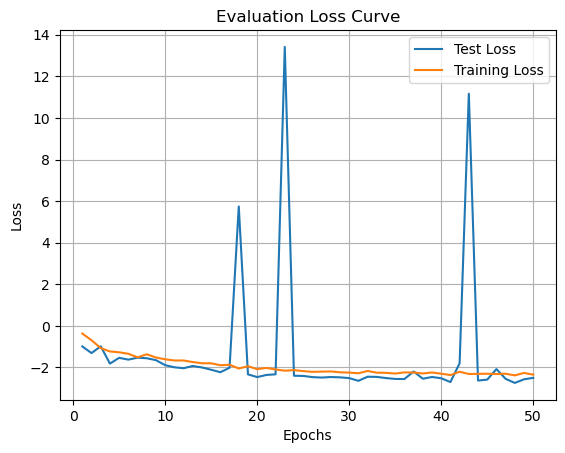

In [114]:
# Plotting the evaluation loss curve
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evaluation Loss Curve')
plt.legend()
plt.grid(True)
# Save the plot
plt.savefig('pets_'+ env_name + '_' + num_samples + '_evaluation_loss_curve.png')
plt.show()

In [115]:
# Define your test dataset and dataloader
#test_dataset = torch.utils.data.TensorDataset(test_x, test_y)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Switch model to evaluation mode
#model.eval()

# Lists to store predictions and true labels
predictions = []
true_labels = []

# Iterate over test data
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        #predictions.extend(outputs.cpu().numpy())
        #true_labels.extend(labels.cpu().numpy())
        #predictions.extend(outputs)
        #true_labels.extend(labels)
        prediction_tensor = outputs[0].cpu()
        predictions.extend(prediction_tensor.numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate Mean Squared Error (MSE) and R-squared
mse = mean_squared_error(true_labels, predictions)
r2 = r2_score(true_labels, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")

Mean Squared Error (MSE): 0.5023264288902283
R-squared: -9.74883298788809e-05


In [116]:
model_weights_file_path = 'pets_'+ env_name + '_' + num_samples +'.pth' 
# Save the trained model
torch.save(model.state_dict(), model_weights_file_path)

In [117]:
model_weights_file_path = 'pets_'+ env_name + '_' + num_samples +'.pth' 
model.load_state_dict(torch.load(model_weights_file_path))

<All keys matched successfully>

In [22]:
class MDP:
    def __init__(self, model, env):
        self.model = model
        # Create the CartPole environment
        self.env = env
        self.df_discrete = None
        self.df_MDP = None
        
    def generateSample(self, filename, episodes=1000, max_episode_length=2000, noise = 0):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        state_size = self.env.observation_space.shape[0]
        #state_size = 4
        samples = []
        for episode in range(episodes):
            state = self.env.reset()[0]
            episode_length = 0

            while episode_length <= max_episode_length:
                action = self.env.action_space.sample()
                input_model = list(state) + [action]
                input_model = torch.tensor(input_model, device=device, dtype=torch.float32)
                input_model = input_model.unsqueeze(0)

                #print(f"Model is on device: " + str(next(model.parameters()).device))
                #print(f"input_model is on device: {input_model.device}")
                mean_next_state, std_next_state = self.model(input_model)
                
                # Apply softplus to std_next_state to ensure it is positive
                std_next_state = torch.nn.functional.softplus(std_next_state)

                # Create a normal distribution with the given mean and std
                normal_dist = torch.distributions.Normal(mean_next_state, std_next_state)

                # Sample from the distribution
                next_state = normal_dist.sample()[0]
                
                print(next_state)
                state = list(state)
                action = [str(action)]
                next_state = next_state.tolist()
                next_state, reward, done = next_state[:-2], next_state[-2], next_state[-1]
                reward = [reward]
                #next_state = [noise*random.uniform(-1, 1)+next_state[i] for i in range(state_size)]
                #next_state = self.add_noise(next_state)

                sample = state + action + reward + next_state
                samples.append(sample)
                state = next_state
                
                episode_length += 1
                if done:
                    break
                    
        df = pd.DataFrame(samples)
        df.columns = [f'variable_{i}' for i in range(state_size)] + ['action','reward'] + [f'nx_variable_{i}' for i in range(state_size)]
        self.df_data = df
        df.to_csv(filename, index=False)  

In [23]:
# Create the CartPole environment
env = gym.make(env_name)
mdp = MDP(model,env)
sample_filename = 'pets_'+ env_name + '_sample.csv'
mdp.generateSample(max_episode_length = 200, noise = 0, filename = sample_filename)

tensor([ 0.1654, -0.0301,  0.3898,  0.5130,  2.6106,  2.3905], device='cuda:0')
tensor([ 1.4108, -0.8641, -0.1457, -0.0154,  0.9338,  0.0676], device='cuda:0')
tensor([ 1.0270,  0.6256, -0.1408,  0.8884,  0.7679,  0.4562], device='cuda:0')
tensor([ 0.4088, -0.4062,  0.1312, -1.0361,  1.5224,  0.3825], device='cuda:0')
tensor([-1.4802, -0.3677,  1.1198,  2.3241,  0.3899,  1.4311], device='cuda:0')
tensor([-1.2357, -0.4801,  0.2119,  0.9065,  0.5008, -0.6730], device='cuda:0')
tensor([ 0.1111,  0.0230, -0.9774,  0.1825,  0.7572,  1.1621], device='cuda:0')
tensor([ 0.0390,  0.3149, -1.0687,  0.2676,  1.1685, -0.8890], device='cuda:0')
tensor([-0.3300,  0.3182, -0.8568,  0.1962,  0.2133,  0.9120], device='cuda:0')
tensor([-0.5371, -0.1642,  1.4873,  1.6403,  0.7515,  1.8590], device='cuda:0')
tensor([ 1.2373, -0.2357,  0.2457, -0.3049,  2.4268, -1.3072], device='cuda:0')
tensor([ 0.8914, -0.8075, -1.3605, -0.0467,  0.6689,  0.8879], device='cuda:0')
tensor([-0.2599,  1.5501, -0.1993,  0.17

tensor([1.0850, 0.1125, 0.6876, 0.2105, 1.1425, 0.4903], device='cuda:0')
tensor([ 0.3478, -0.4726, -0.2491, -0.3118, -1.5287,  0.0586], device='cuda:0')
tensor([ 0.5870, -0.2963, -0.5789,  0.6127,  0.6132, -0.4783], device='cuda:0')
tensor([ 0.7021,  0.5579,  0.5873,  1.0946, -0.1076, -0.5084], device='cuda:0')
tensor([ 1.0349,  0.8588,  0.8620, -0.7269,  0.8744,  0.8125], device='cuda:0')
tensor([-1.1895, -0.1737, -0.6357, -0.7991,  3.0907,  0.1022], device='cuda:0')
tensor([-1.3146, -0.3235,  1.5072, -1.0832, -0.1327, -0.9947], device='cuda:0')
tensor([ 0.2635,  0.2117,  0.5891, -1.5988,  0.6783,  1.0589], device='cuda:0')
tensor([-0.4233, -0.2452,  0.0167, -2.2694,  1.9893, -0.6650], device='cuda:0')
tensor([ 0.4041,  0.8048, -0.1884, -0.5585,  0.5126,  0.0645], device='cuda:0')
tensor([-0.8618, -0.2369,  0.4597,  0.7805,  0.7159,  0.3921], device='cuda:0')
tensor([-0.5027,  0.9398,  0.5926,  0.9223,  1.3524, -0.2073], device='cuda:0')
tensor([-0.2987,  1.4656, -0.4955,  0.4845, -2

tensor([ 0.5928,  0.1320, -1.0369,  0.0232,  2.2396, -1.3754], device='cuda:0')
tensor([ 0.0532, -1.1388, -0.5170, -1.6070, -0.1234,  1.6635], device='cuda:0')
tensor([-0.5792,  0.9572,  0.7488, -0.1507,  1.8176,  0.5596], device='cuda:0')
tensor([-0.5299, -0.7466, -0.6418, -0.4403, -0.1374,  1.4354], device='cuda:0')
tensor([-0.8116,  0.9355,  0.0267,  0.7039,  1.6125, -0.5264], device='cuda:0')
tensor([ 0.1759, -0.4199, -1.0381,  0.1498, -0.0202,  1.0011], device='cuda:0')
tensor([ 0.0995, -0.8837,  0.4120, -0.0886,  0.2577,  0.0758], device='cuda:0')
tensor([-0.4757, -1.7228,  0.5146,  0.5043,  0.0646,  0.6256], device='cuda:0')
tensor([-0.3232,  0.9451, -0.1446,  0.6907,  1.9596,  0.6726], device='cuda:0')
tensor([ 0.2889, -0.3376,  0.3544, -0.2076,  0.6670,  0.4560], device='cuda:0')
tensor([-0.1301, -0.5471, -0.0579, -1.5002,  0.4419, -1.2546], device='cuda:0')
tensor([ 0.5615, -0.3376, -1.1696,  0.3677, -0.2856, -0.5937], device='cuda:0')
tensor([-0.5574,  0.0565,  0.3623,  1.46

tensor([ 0.4199, -0.3068,  0.1074,  0.2429, -2.1633,  1.0438], device='cuda:0')
tensor([ 0.0943,  0.2792, -0.4461, -0.3921, -0.7202,  0.4923], device='cuda:0')
tensor([-0.7251,  0.3024, -2.2381,  1.3541,  1.7743, -0.1651], device='cuda:0')
tensor([0.5114, 0.1176, 0.4793, 0.6481, 1.8811, 0.5701], device='cuda:0')
tensor([ 1.3661,  0.7816, -1.3586,  1.2747,  0.4976,  1.0141], device='cuda:0')
tensor([ 0.0222, -0.0085, -0.0937,  1.4244, -0.4446, -0.4114], device='cuda:0')
tensor([ 0.3795,  0.5331,  1.5050, -0.2056,  1.6440,  0.2674], device='cuda:0')
tensor([-0.5097, -0.6882, -0.9865, -1.0841,  1.0997,  3.8269], device='cuda:0')
tensor([ 1.1764,  0.5022,  0.3170,  0.0949,  0.9973, -0.4490], device='cuda:0')
tensor([-0.0993, -0.8164,  0.1168,  0.6134,  2.7780,  0.4799], device='cuda:0')
tensor([-0.5215,  0.0199, -1.3991,  0.0770,  1.5387,  1.5100], device='cuda:0')
tensor([ 0.1656,  0.4775, -0.2585, -1.3801,  0.1814,  1.1352], device='cuda:0')
tensor([-1.0749,  1.0784,  0.9996, -0.2028,  1

tensor([ 0.5126, -1.2537, -1.4187,  1.0362,  2.5243, -0.0189], device='cuda:0')
tensor([-1.5043, -0.3977, -0.8793, -1.3641,  1.8113,  0.7508], device='cuda:0')
tensor([ 0.4186,  0.7465, -1.3854,  0.1713, -0.9757, -0.5986], device='cuda:0')
tensor([ 0.4450, -0.5195,  0.7095,  0.1618, -0.4014, -0.2913], device='cuda:0')
tensor([-0.5174, -0.5063, -0.2924, -0.2002,  1.5715,  1.2689], device='cuda:0')
tensor([-0.2524, -1.0874,  0.0719,  0.1631,  0.9649, -0.7460], device='cuda:0')
tensor([-0.1378,  0.1807,  1.1252, -2.4531, -0.5937, -0.3380], device='cuda:0')
tensor([-0.3259, -1.3393, -1.7077,  1.3942,  1.5892,  0.1738], device='cuda:0')
tensor([-0.9347, -0.5230, -1.1887, -0.3818, -0.0597,  1.1598], device='cuda:0')
tensor([ 1.5007,  1.0584, -0.5452, -0.0953,  2.2851,  0.7812], device='cuda:0')
tensor([-0.4510, -0.5302,  0.7312,  0.6829,  0.1885, -0.4708], device='cuda:0')
tensor([ 0.3386, -0.2669, -0.5017,  1.3968,  0.9196, -0.1057], device='cuda:0')
tensor([ 0.2916, -0.1879, -0.2992,  1.06

tensor([-0.8753,  0.9270,  0.8644, -0.0532, -1.7836,  1.6281], device='cuda:0')
tensor([-0.0986,  0.0577, -0.8814, -0.5796, -0.5662,  2.1368], device='cuda:0')
tensor([ 0.3699, -0.1114,  0.5306,  0.6796,  0.8683,  0.5938], device='cuda:0')
tensor([-1.0636,  0.8091, -0.1361,  0.6185,  0.8231,  0.0642], device='cuda:0')
tensor([-0.3254, -0.8396,  0.3630, -1.4239, -0.3126, -0.5855], device='cuda:0')
tensor([ 1.1204, -1.8892,  0.4857, -1.4147,  0.9216, -0.7091], device='cuda:0')
tensor([ 0.1988,  0.3395, -1.0221, -0.9334,  0.4898,  0.3642], device='cuda:0')
tensor([ 0.5699,  0.5943,  0.3894, -0.3123,  0.7505,  0.1723], device='cuda:0')
tensor([-0.3307,  0.2498, -0.1518, -0.5108,  0.5262,  1.5446], device='cuda:0')
tensor([-0.0737,  0.4998, -0.9178, -0.6917, -1.0261,  1.3445], device='cuda:0')
tensor([ 0.7291,  0.3274,  0.5539, -1.0465, -0.5610,  0.4935], device='cuda:0')
tensor([ 0.0374,  0.9221, -1.0270,  1.2782,  0.2080,  0.3646], device='cuda:0')
tensor([ 0.1996, -0.5156,  0.3761,  0.32

tensor([ 1.0907, -0.0859, -1.6029, -2.1068, -1.1646,  1.0072], device='cuda:0')
tensor([ 0.0418, -0.8574,  0.1010, -0.7445,  0.4243,  0.7159], device='cuda:0')
tensor([-0.6217,  0.1765, -0.3440, -0.2231,  0.7532,  1.3943], device='cuda:0')
tensor([-0.4017,  0.3494, -1.2301,  0.0038, -0.7915, -0.1299], device='cuda:0')
tensor([ 0.2222,  0.5753, -0.0886, -1.6748, -0.9395, -0.2698], device='cuda:0')
tensor([ 0.6548,  0.6784, -1.0118,  0.0426,  0.8230, -0.2309], device='cuda:0')
tensor([ 0.8251, -0.5475, -0.2680,  1.1908,  2.2349, -0.5288], device='cuda:0')
tensor([ 0.2861, -0.3480, -0.1166,  0.1771,  1.5084,  0.7106], device='cuda:0')
tensor([ 6.0495e-05, -1.6944e-01,  3.4933e-01, -3.2124e-01,  2.3995e-01,
        -2.3407e-01], device='cuda:0')
tensor([-0.4631,  0.2841, -0.5427, -0.7339,  0.4127,  0.4332], device='cuda:0')
tensor([ 0.4339, -0.4639, -0.7245,  0.7565, -0.3267, -0.3302], device='cuda:0')
tensor([-0.7778,  0.0196, -0.0749, -0.5919,  1.1939,  2.6143], device='cuda:0')
tensor([

tensor([ 0.7802,  1.5112, -1.3480, -0.4259,  1.1163, -0.6094], device='cuda:0')
tensor([-0.1141,  0.2452, -0.5743,  0.8292,  1.7599,  0.1472], device='cuda:0')
tensor([ 1.0384, -0.4313,  1.0718, -1.2043, -0.5688,  0.5987], device='cuda:0')
tensor([-0.7979,  0.0736, -0.4316,  0.0396,  0.9506, -0.0034], device='cuda:0')
tensor([ 0.2331,  0.2244, -0.4271,  0.5030, -0.5121,  2.4449], device='cuda:0')
tensor([ 1.1606, -0.9064, -0.1182,  0.0375,  0.0820,  1.3411], device='cuda:0')
tensor([ 0.6350,  0.5105, -1.5816, -0.8735,  1.1934,  0.4730], device='cuda:0')
tensor([-0.5843, -0.5259, -0.3777, -0.0493,  1.5204,  0.6269], device='cuda:0')
tensor([ 0.6545, -0.8858, -0.9067,  0.9643,  0.0727, -0.0659], device='cuda:0')
tensor([-1.1663,  0.6884, -1.9233,  0.3453, -1.2174,  0.9115], device='cuda:0')
tensor([ 0.4406,  0.2736, -0.5416, -0.1890, -1.3136, -0.1141], device='cuda:0')
tensor([ 0.1866,  1.5747, -1.5683, -0.3139, -1.1940,  2.7280], device='cuda:0')
tensor([ 0.6736,  0.6063,  0.2818, -0.60

tensor([ 0.0632, -1.6911, -1.8013, -1.0649,  0.7873, -0.3421], device='cuda:0')
tensor([-0.5291,  0.8185,  1.0998,  0.0844, -0.2677, -0.9806], device='cuda:0')
tensor([-0.0041, -0.7813, -1.1723,  0.4373, -0.0501,  2.2945], device='cuda:0')
tensor([-0.1258, -0.0773, -0.4476, -1.0913,  1.7402,  1.1471], device='cuda:0')
tensor([-0.1504,  0.0937, -0.7319, -0.3437, -0.1180, -0.1691], device='cuda:0')
tensor([ 0.7006,  0.5508,  0.9658, -0.2134, -2.2592,  0.6642], device='cuda:0')
tensor([ 0.5635, -0.7007, -0.3750,  0.1795, -0.4331, -0.0443], device='cuda:0')
tensor([-0.3138,  1.7777,  0.0503, -0.8284,  2.2197,  0.8396], device='cuda:0')
tensor([-0.8490,  0.4395,  1.7862,  0.0412, -1.3673, -1.7790], device='cuda:0')
tensor([ 0.4741, -0.2558, -1.0660,  0.8770,  1.4822,  0.6193], device='cuda:0')
tensor([-1.0178, -1.0097, -0.3755,  0.1802,  1.3756,  1.4424], device='cuda:0')
tensor([ 0.0838, -1.3520, -0.2228,  0.8702, -0.1298, -0.8926], device='cuda:0')
tensor([ 0.6130, -0.6847,  2.0419, -0.64

In [11]:
for inputs, labels in train_loader:
    print(inputs.shape)
    break

torch.Size([32, 5])


In [12]:
state = env.reset()[0]

action = env.action_space.sample()
input_model = list(state) + [action]
input_model = torch.tensor(input_model, device=device, dtype=torch.float32)
print(input_model.shape)

torch.Size([5])
